In [ ]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DXG DATA PREPARATION**

In [ ]:
# Read Data
df = pd.read_csv('DXG Historical Data 1_6 Fed.csv')

In [ ]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DXG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DXG,2018-01-02,13401.400
1,DXG,2018-01-03,13371.100
2,DXG,2018-01-04,13522.400
3,DXG,2018-01-05,13159.400
4,DXG,2018-01-06,13363.575
...,...,...,...
2338,DXG,2024-05-28,16800.000
2339,DXG,2024-05-29,16850.000
2340,DXG,2024-05-30,16850.000
2341,DXG,2024-05-31,16800.000


In [ ]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [ ]:
# Sizing
size = int(len(df1))

# 8 : 2 Ratio
train_data = df1[:int(0.8 *size)]
test_data = df1[int(0.8 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1874
Test lenght: 469


In [ ]:
# Train_data MAX Value
train_data.max()

unique_id                    DXG
ds           2023-02-18 00:00:00
y                        46750.0
dtype: object

# **TRAINING PROCESSS**

In [ ]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 200,  # 200 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 279 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
683 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [ ]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [ ]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
469    26255.921875
470    24622.144531
471    24196.933594
472    16382.017578
473    12142.945312
474    13575.134766
475    17287.658203
476    20607.335938
477    35421.906250
478    29139.884766
479    24208.330078
480    28122.687500
481    20707.576172
482    28961.455078
483    26891.919922
484    34541.464844
485    30772.958984
486    32546.644531
487    23011.048828
488    14354.769531
489    13748.500000
490    11829.683594
491    14797.082031
492    22935.324219
493    35957.773438
494    18659.304688
495    16557.802734
496    26112.687500
497    26165.019531
498    34261.253906
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
499    32294.550781
500    23658.875000
501    30410.597656
502    12304.194336
503    21142.677734
504    17752.615234
505    20283.457031
506    28845.359375
507    34834.468750
508    34072.734375
509    34597.097656
510    32099.312500
511    29516.121094
512    26046.179688
513    13376

# **EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 5197.3930671003245
Mean Absolute Percentage Error (MAPE): 0.294089749903286
Mean Square Error (MSE): 40939849.37005604
Root Mean Square Error (RMSE): 6398.425538369267


# **VISUALIZATION**

In [ ]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

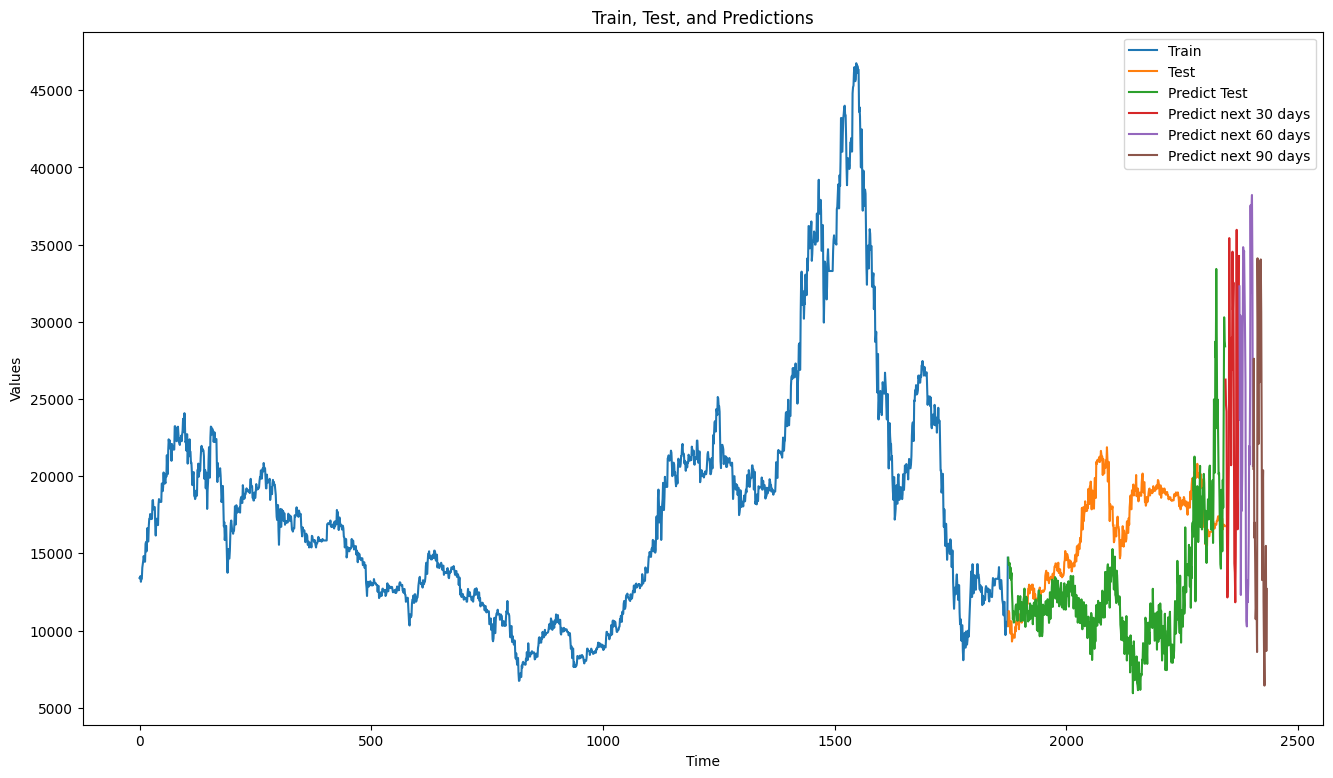

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [ ]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [ ]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[21610.945 22036.195 22484.908 23330.984 24308.785 24977.334 25425.797
 25727.393 25448.537 24393.215 24370.027 24192.62  23819.262 23809.025
 23528.623 23555.47  24020.805 24155.904 25124.266 25121.992 24865.223
 24307.346 23385.451 22363.578 22302.51  22174.27  22083.781 22411.951
 22571.924 23654.299]

Predicted Data for the next 60 days:
[24613.133 25841.521 26694.127 27670.828 28050.787 27692.984 26830.398
 25764.855 24459.635 23045.848 22812.248 21705.508 20566.598 20250.03
 20611.85  21397.979 21874.936 22519.252 23377.99  23325.348 23600.713
 23419.455 23111.947 23211.611 22498.107 22291.035 22765.818 22855.951
 23437.598 23699.38 ]

Predicted Data for the next 90 days:
[23657.35   23280.473  23003.041  23117.295  23350.668  23073.297
 22619.984  22664.014  22547.332  22532.176  22663.486  22635.422
 22812.535  23492.328  23844.318  23802.27   23635.992  23334.77
 22887.889  22284.627  21514.271  20566.102  19429.404  18093.459
 16547.549  

# **RE - EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 5084.846868406295
Mean Absolute Percentage Error (MAPE): 0.28707354910335475
Mean Square Error (MSE): 38126544.76899043
Root Mean Square Error (RMSE): 6174.669608083531


# **RE - VISUALIZATION**

In [ ]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

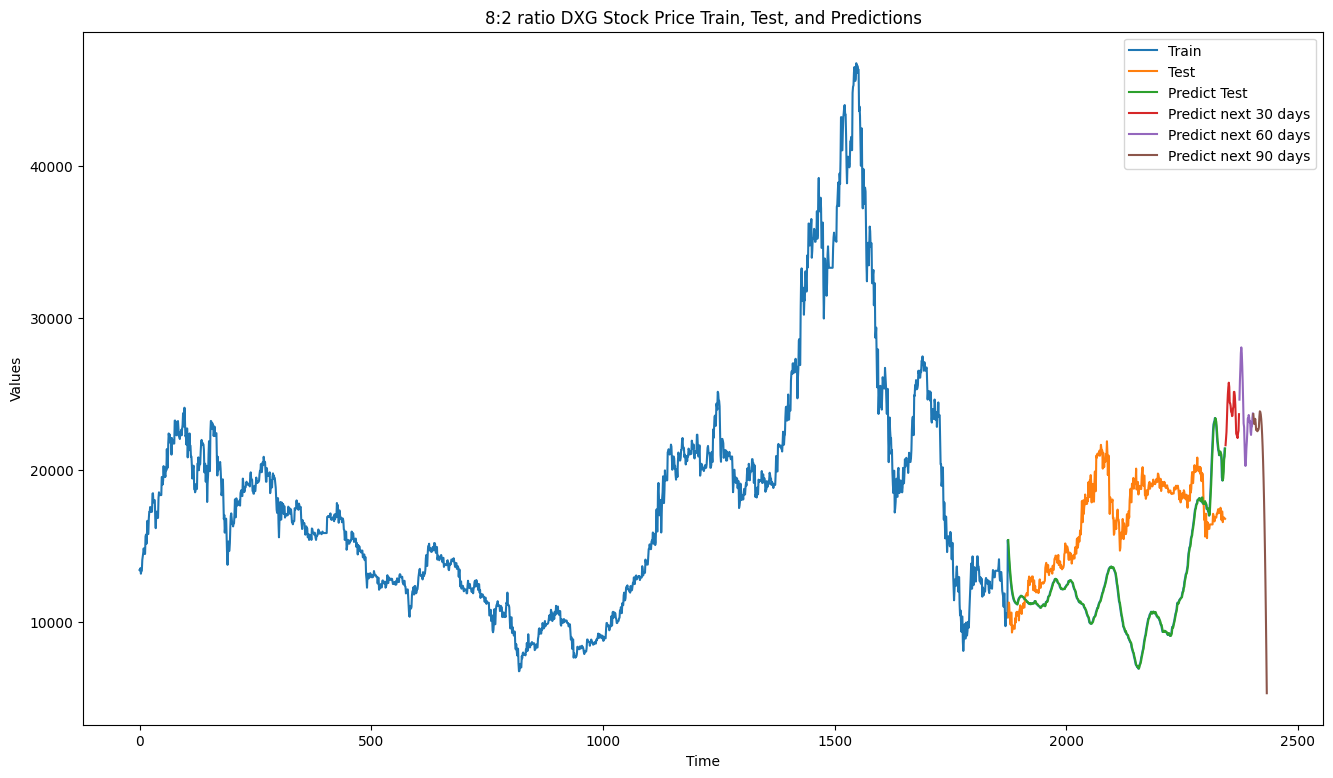

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('8:2 ratio DXG Stock Price Train, Test, and Predictions')
plt.show()